In [11]:
from llm_utils import *
from llm_schema_config import *
from llm_prompts import *
import uuid

In [12]:
from openai import OpenAI

with open('key.txt', 'r') as file:
    key = file.read().replace('\n', '')

client = OpenAI(
    api_key=key
)

To determine the root nodes for the causal graph, we need to identify variables that are likely to be exogenous, meaning they are not influenced by other variables in the model.

1. **AGEP**: Age is typically considered an inherent characteristic of individuals and is not influenced by other demographic factors in this context, making it a good candidate for a root node.

2. **SEX**: Similar to age, sex is a biological characteristic that does not change based on other demographic variables. It is also a strong candidate for a root node.

3. **HOUSING_TYPE**: This variable indicates the type of housing and can be influenced by socioeconomic factors but may also be influenced by other demographic variables, making it less ideal as a root node.

4. **OWN_RENT**: This variable indicates housing tenure (owning vs. renting) and is influenced by economic status, age, and possibly education. It is not a root variable.

5. **DENSITY**: Population density could be influenced by various factors 

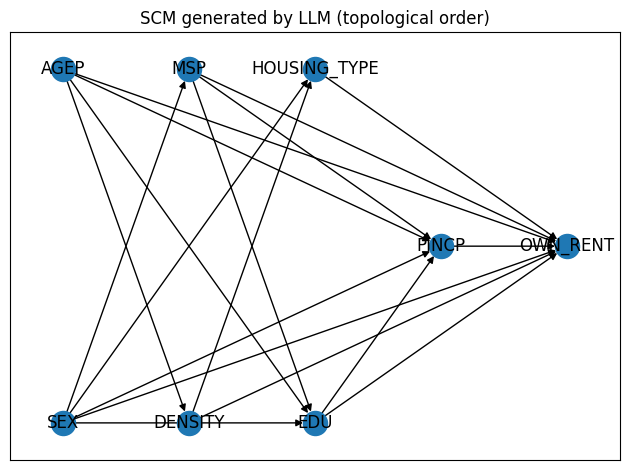

To define the structural equations based on the causal relationships established, we'll parameterize each variable according to whether it is a root node or has parent nodes. Let's create the equations step by step, ensuring that they comply with the given schema.

### Root Variables
1. **AGEP**: This variable (age) is continuous and can be modeled with a uniform distribution given the range (0, 95).
   - **Equation**: `AGEP ~ Uniform(0, 95)`

2. **SEX**: This variable (sex) is categorical with values [1, 2]. We can assume a categorical distribution with some probabilities for each category, say 50% for each.
   - **Equation**: `SEX ~ Categorical([0.5, 0.5])`

### Non-Root Variables
3. **EDU**: This variable depends on `AGEP` and `SEX`. We can define different probabilities for education levels based on age groups and sex.
   - **Equation**: `EDU ~ Categorical(EDU_probs[AGEP, SEX])` where `EDU_probs` is a pre-defined function that returns probabilities for each education level based on

In [13]:
message_history = CENSUS_PROMPT.copy()
message_history, _ = general_prompt(prompt_step_1, message_history=message_history, client=client, args={'schema': SCHEMA})
message_history, root_rels = general_prompt(prompt_step_2, message_history=message_history, client=client, args={})
message_history, non_root_rels = general_prompt(prompt_step_3, message_history=message_history, client=client, args={})
relationships = root_rels + non_root_rels
if contains_cycles(relationships):
    message_history, relationships = general_prompt(prompt_remove_cycles, message_history=message_history, client=client, args={'relationships': relationships})

G = nx.DiGraph()
for relationship in relationships:
    source, target = map(str.strip, relationship.split("->"))
    G.add_edge(source, target)

assert nx.is_directed_acyclic_graph(G), "the graph is not a DAG - contains cycles"

print("DAG relationships:")
for edge in G.edges:
    print(f"{edge[0]} -> {edge[1]}")

plot_dag_layout(G)

schema_variables = set(SCHEMA.keys())
dag_variables = set(G.nodes)
missing_variables = schema_variables - dag_variables

assert len(missing_variables) == 0, f"The following variables are missing from the DAG: {missing_variables}"

message_history, pseudocode = general_prompt(prompt_step_4, message_history=message_history, client=client, args={})

In [14]:
message_history, pyro_code = general_prompt(prompt_generate_pyro_code, message_history=message_history, client=client, args={'pseudocode':pseudocode}, extract_answer=extract_pyro_code)
final_pyro_code, attempts = robust_retrieve_pyro_model(pyro_code, prompt_fix_this_code=prompt_fix_code, message_history=message_history, client=client)

try:
    df = sample_from_trace(final_pyro_code)
except Exception as e:
    print("Error sampling from the Pyro model:")
    print(e)
    print("Final Pyro code:")
    print(final_pyro_code)
    print("Fix Attempts:")
    print(attempts)

# store df as a csv file with an id
df_id = str(uuid.uuid4()).split("-")[0]
df.to_csv(f"{df_id}.csv", index=False)

Here’s the Python code that implements the specified structural causal model (SCM) using Pyro. This code includes the necessary distributions and follows the relationships outlined in the previous step.

```python
<PyroCode>
import pyro
import pyro.distributions as dist
import torch

def model():
    # Sample root variables
    AGEP = pyro.sample("AGEP", dist.Uniform(0, 95))
    SEX = pyro.sample("SEX", dist.Categorical(torch.tensor([0.5, 0.5])))
    
    # Sample marital status based on AGEP and SEX
    MSP_probs = ...  # Define your function or array for MSP probabilities based on AGEP and SEX
    MSP = pyro.sample("MSP", dist.Categorical(MSP_probs[AGEP, SEX]))
    
    # Sample education status based on AGEP and SEX
    EDU_probs = ...  # Define your function or array for EDU probabilities based on AGEP and SEX
    EDU = pyro.sample("EDU", dist.Categorical(EDU_probs[AGEP, SEX]))
    
    # Sample personal income based on EDU and MSP
    mu_PINCP = ...  # Define your function for mea

TypeError: exec() arg 1 must be a string, bytes or code object